# Imports

In [1]:
import time
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

# Single

## CPU

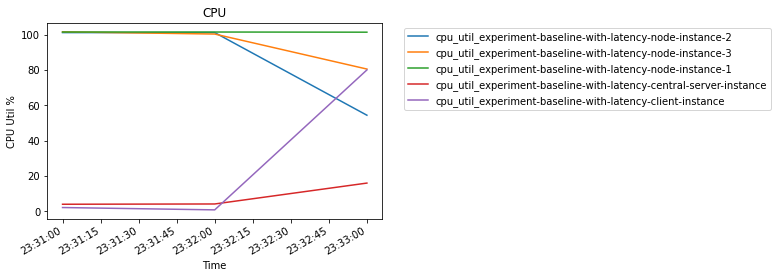

In [4]:
df = pd.read_csv("data/20210721/monitoring_experiment-baseline-with-latency.csv")
columns = df.columns
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for col in columns: 
    if col.startswith("cpu_"):
        ax.plot(df.index, df[col]*100, label=col)
# set title and legend
ax.set_title('CPU')
ax.set_ylabel("CPU Util %")
ax.set_xlabel("Time")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()

fig.savefig("out/cpu_util.png")
plt.show()

## IO

In [5]:
df = pd.read_csv("export.csv")
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for col in columns: 
    if col.startswith("io_"):
        ax.plot(df.index, df[col]*100, label=col)
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth between Nodes')
ax.set_ylabel("CPU Util %")
ax.set_xlabel("Time")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()

fig.savefig("out/cpu_util.png")
plt.show()

FileNotFoundError: [Errno 2] File export.csv does not exist: 'export.csv'

## IOPS

NameError: name 'columns' is not defined

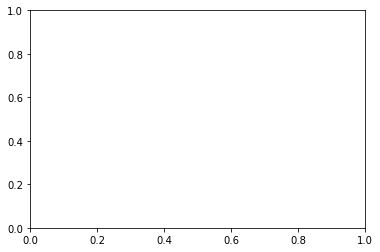

In [ ]:
df = pd.read_csv("monitoring_experiment-baseline-with-latency.csv")
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for col in columns: 
    if col.startswith("iops_"):
        ax.plot(df.index, df[col]*100, label=col)
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth between Nodes')
ax.set_ylabel("CPU Util %")
ax.set_xlabel("Time")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()

fig.savefig("out/cpu_util.png")
plt.show()

# Comparison

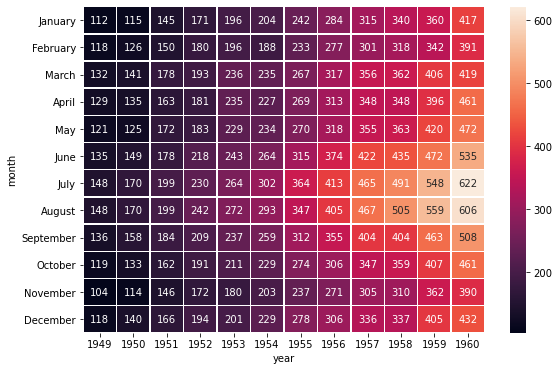

In [ ]:
# Load the example flights dataset and convert to long-form
flights_long = sns.load_dataset("flights")
flights = flights_long.pivot("month", "year", "passengers")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(flights, annot=True, fmt="d", linewidths=.5, ax=ax)